In [55]:
using Pipe
using DataFrames
# using StatsPlots
using CSV
# using RollingFunctions
using Query
# using GLMakie

using JSON
using DataFrames
using Dates
using Colors
# using ColorSchemes
using Indicators

import Colors
using Plots
using Interact
using JuliaDB
using Interact
using Wavelets,WaveletsExt
using LinearAlgebra
# import Pkg; Pkg.add("ShiftedArrays")
# using ShiftedArrays
include("utils.jl")

calc_wavelet (generic function with 1 method)

In [20]:
json_data_folder = "../user_data/data/binance"
json_filename = "BTC_USDT-1m.json"
json_filepath = "$json_data_folder/$json_filename"
f = open(json_filepath, "r")
json_data = JSON.parse(f)
close(f)

In [21]:
dfa = DataFrame(unix_time = Int64[], open=Float64[], high=Float64[], low=Float64[], close=Float64[], volume=Float64[])
for r in json_data push!(dfa, r) end
dfa.unix_time .= dfa.unix_time ./1000
# dfa.time .= unix2datetime.(dfa.unix_time)

insertcols!(dfa, :time => unix2datetime.(dfa.unix_time))
nrow(dfa)

129177

In [22]:
start_date = DateTime(2021, 3, 1)
end_date = DateTime(2021, 5, 27)
vdf = dfa[(dfa.time .>= start_date) .& (dfa.time .<= end_date) , :]
ut, tt, hh, ll, cc = vdf.unix_time, vdf.time, vdf.high, vdf.low, vdf.close
# h14max = [fill(vdf[1,:high],8-1)...,rollmax(vdf.high, 8)...]
#  length(h14max), length(vdf.close)
# hlc = [hh ll cc]
length(tt)

124757

In [30]:

function get_wavelet(ar, (m, perc, shift))
    fxt = calc_wavelet(ar, m)
    
    shifted_wave1 = (1 + perc/100) * 
        circshift(fxt , Int(trunc(m * shift)))

end

get_wavelet (generic function with 1 method)

In [7]:

function wavelet_sliders()
    
    m_slider = slider(1:200; label="m", default=50)
    perc_slider = slider(-5.0:0.05:5.0; label="%", default=0)
    shift_slider = slider(-1:0.05:1.0; label="shift", default=0)
    
    output = Interact.@map (&m_slider , &perc_slider, &shift_slider)
#     output = Interact.@map circshift(get_wavelet(ar, m)*(1+ perc/100), Int(trunc(m*shift)) )
    
    wdg = Widget(["m_slider" => m_slider, "perc_slider" => perc_slider, "shift_slider" => shift_slider], output = output)
    @layout! wdg hbox(:m_slider, :perc_slider, :shift_slider)
end

wavelet_sliders (generic function with 1 method)

In [32]:
wave1[][100]

LoadError: UndefVarError: wave1 not defined

In [146]:


# wave1 = Interact.@map get_wavelet(&par, &wave_slds_1[:m_slider]) 

# shifted_wave1 = Interact.@map (1 + &wave_slds_1[:perc_slider]/100) * 
#     circshift(&wave1 , Int(trunc(&wave_slds_1[:m_slider] * &wave_slds_1[:shift_slider])))


# function draw_it_all(ar, (m, perc, shift))
    
#     wave_ar = get_wavelet(ar, m)
#     plt = plot(ar, size=(1200,600), legend=nothing)
#     plt1 = plot!(circshift(wave_ar*(1+ perc/100), Int(trunc(m*shift)) ), color=:red)
#     dom"div"(plt1)
# end
subs=1
ar_len = length(cc)
wsl = window_slider(ar_len, subs=subs)
wst = Interact.@map first(&wsl)
wed = Interact.@map last(&wsl)
wsz = Interact.@map &wed - &wst
plot_box = Observable{Any}(dom"div"())
rng = Interact.@map &wst: &wed
wcc = Interact.@map cc[&rng]
wut = Interact.@map ut[&rng]
wtt = Interact.@map tt[&rng]

wvmsl = slider(1:200; label="m", default=50)
wvmsl[] = 5
# prcc = Interact.@map &wst > 1 ? cc[&wst - &wsz:&wst] : cc[&rng]
# wt = wavelet(WT.haar)
# xt = Interact.@map length(&prcc) > 0 ? dwt(&prcc, wt, &wvmsl) : []
# xtcff = Interact.@map length(&xt) > 0 ? (&xt)[1:2^(&wvmsl-1)] : []
# xtcff = []

xt = Interact.@map dwt(&wcc, wt, Int64(&wsz/2))
Interact.@map threshold!(&xt, BiggestTH(), &wvmsl)
fxt = Interact.@map idwt(&xt, wt)


# # put = Interact.@map ut[&rng]
# # wtt = Interact.@map tt[&rng]


function draw_it_all(wcc,fxt)    
   
    f1 = plot(wcc, size=(1200,500))
#     length(xtcff) > 0 && hline!(xtcff)
    plot!(fxt)
#     plt = plot(f1,f2, size=(1200,500))
    dom"div"(f1) 
end

map!(draw_it_all, plot_box, wcc, fxt)
ui = dom"div"(wvmsl,
        plot_box,wsl
    )
wsl[:log2_slider][] = 9
ui

LoadError: InexactError: Int64(127.5)

In [139]:
# dwt(prcc[], wt, &wvmsl)
# prcc
# Plots.hline(xt[][1:2^4])
# xtcff[]

In [9]:
ar=cc
mp = @manipulate for 
            s in slider(1:12000; label="s", default=7),
            m1 in slider(1:100; label="m", default=11)
#             m2 in slider(1:100; label="m", default=11)
    wsize = 2^9
    wstart = 1400 + s
    wend = wstart+wsize-1
    wrng = wstart:wend
    
    xar = ar[wrng]
    plot(xar, size=(1200,400),legend=nothing)
#     plot!(calc_wavelet(xar,16))
    wave_window_size = Int(wsize/2)
    
#     wave1 = calc_wavelet(xar[1:wave_window_size],2)
#     wave2 = calc_wavelet(xar[1:wave_window_size],1)
#     plot!(wave1)
#     plot!(wave2)
#     plot!(wave2, fillrange=wave2*0.99, fillalpha=0.05)
#     , fillranges=[0.995*wave1_ar,1.05*wave1_ar], fillalpha=0.01,
    wave1_ar = [last(calc_wavelet(ar[i-wave_window_size+1:i],m1, WT.haar)) for i in wrng]
    plot!(wave1_ar, lw=1.8)
    
#     wave2_ar = [last(calc_wavelet(ar[i-wave_window_size+1:i],m2, WT.haar)) for i in wrng]
#     plot!(wave2_ar)
    
#     wave3_ar = [last(calc_wavelet(ar[i-Int(wave_window_size/2)+1:i],5, WT.db6)) for i in wrng]
#     plot!(wave3_ar, fillranges=[0.995*wave1_ar,1.05*wave1_ar], fillalpha=0.01)
    
    vline!([Int(wsize/2)])
    
    
end 
mp

LoadError: MethodError: no method matching dwt(::Vector{Float64}, ::Wavelets.WT.Haar)
[0mClosest candidates are:
[0m  dwt(::AbstractArray{T, N} where N, [91m::OrthoFilter[39m) where T<:Union{AbstractFloat, Complex} at /Users/johnsmith/.julia/dev/Wavelets/src/mod/Transforms.jl:114
[0m  dwt(::AbstractArray{T, N} where N, [91m::OrthoFilter[39m, [91m::Integer[39m) where T<:Union{AbstractFloat, Complex} at /Users/johnsmith/.julia/dev/Wavelets/src/mod/Transforms.jl:114
[0m  dwt(::AbstractArray{T, N} where N, [91m::GLS[39m) where T<:Union{AbstractFloat, Complex} at /Users/johnsmith/.julia/dev/Wavelets/src/mod/Transforms.jl:124
[0m  ...

In [ ]:
 [ (i,j, j/60, j/60/24) for (i,j) in [(i, 2^i) for i in 1:15]]

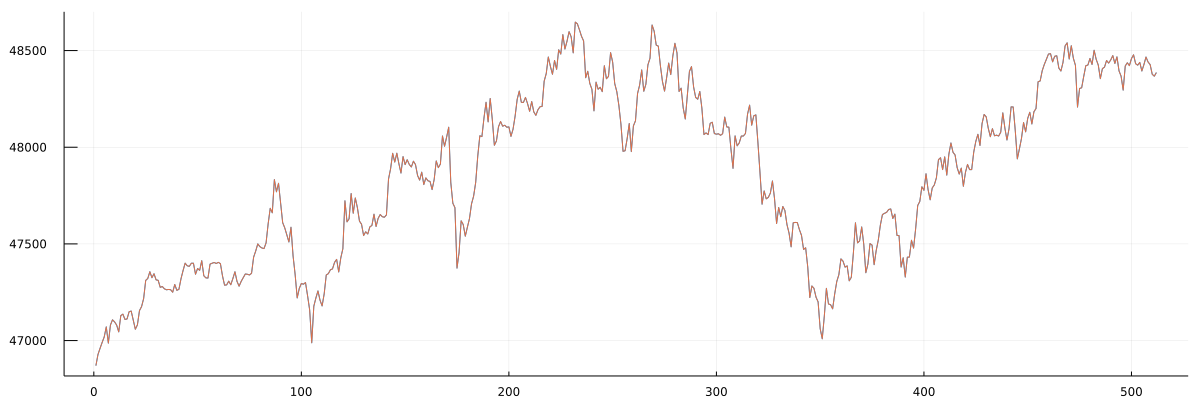

In [10]:
using WaveletsExt
s = 5000
# mp = @manipulate for 
#             s in slider(1:12000; label="s", default=7)
    wsize = 2^9
    wstart = 1400 + s
    wend = wstart+wsize-1
    wrng = wstart:wend
    
    xar = ar[wrng]

y = acwt(xar, wavelet(WT.haar))
z = iacwt(y)
#     y = wpd(xar, wavelet(WT.db4))

    plot(xar, size=(1200,400),legend=nothing)  
    plot!(z)
#     vline!([Int(wsize/2)])
    
    
# end 
# mp

In [18]:
y

512×10 Matrix{Float64}:
 1.08268e6  -2001.08   327.091    …  -349.697    -403.281    -556.277
 1.08268e6  -2026.42   246.225       -650.196    -574.62        9.07572
 1.08268e6  -2050.93   166.086       -742.907    -184.751       0.526795
 1.08268e6  -2074.74    86.6097      -653.873      10.4575      0.682358
 1.08268e6  -2097.78     7.67391     -368.638      29.1812     -8.47114
 1.08268e6  -2120.04   -70.8986   …  -161.008      10.1387     48.1858
 1.08268e6  -2141.48  -149.199        -34.7216    -30.015     -62.6355
 1.08268e6  -2161.98  -227.166         36.8137     -2.37375    23.3062
 1.08268e6  -2181.58  -304.937         27.1012     44.5938     13.4209
 1.08268e6  -2200.37  -382.455         14.128      26.0537      2.12132
 1.08268e6  -2218.3   -459.619    …     8.63996   -28.4663      6.53013
 1.08268e6  -2235.3   -536.504         -3.96908   -36.86      -42.1471
 1.08268e6  -2251.33  -612.98           3.23987    13.835      26.9867
 ⋮                                ⋱           

In [12]:
2^9

512

In [2]:
n = length(ar)
wnd = window_slider(20000)
rng = Observable{AbstractRange{Int64}}(1:1)
map!(wnd -> wnd[1]*wnd[2]:(wnd[1]+1)*wnd[2]-1, rng, wnd)
plt = Observables.@map plot(ar[&rng])
A = Observables.@map length(&rng) > 2 ? heatmap(wplotim(ar[&rng])) : nothing
hbox(plt,A)

LoadError: UndefVarError: ar not defined

In [ ]:
length(1:3)

In [ ]:
length(ar)